In [232]:
#Student id: 11471992

from os import listdir
from os.path import isfile, join
import skimage
from matplotlib import pyplot as plt
import pydicom as dicom
import numpy as np


In [267]:
data_path = "./02/"
onlyfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]
print(onlyfiles)
image_num = 20

['000047.dcm', '000052.dcm', '000046.dcm', '000050.dcm', '000044.dcm', '000045.dcm', '000051.dcm', '000041.dcm', '000040.dcm', '000042.dcm', '000043.dcm', '000018.dcm', '000024.dcm', '000030.dcm', '000031.dcm', '000025.dcm', '000019.dcm', '000033.dcm', '000027.dcm', '000026.dcm', '000032.dcm', '000036.dcm', '000022.dcm', '000023.dcm', '000037.dcm', '000021.dcm', '000035.dcm', '000009.dcm', '000008.dcm', '000034.dcm', '000020.dcm', '000039.dcm', '000005.dcm', '000011.dcm', '000010.dcm', '000004.dcm', '000038.dcm', '000012.dcm', '000006.dcm', '000007.dcm', '000013.dcm', '000017.dcm', '000003.dcm', '000002.dcm', '000016.dcm', '000000.dcm', '000014.dcm', '000028.dcm', '000029.dcm', '000015.dcm', '000001.dcm', '000048.dcm', '000049.dcm']


In [234]:
test_img = dicom.read_file(join(data_path, onlyfiles[0]))
print(test_img)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 192
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9328.50.51.253646386109451154639286385517263168219
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.27'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.51.253646386109451154639286385517263168219
(0008, 0020) Study Date                          DA: '19910409'
(0008, 0023) Content Date             

In [235]:
voxel_size = [test_img.PixelSpacing, test_img.SliceThickness]
print(voxel_size)

[[0.938, 0.938], '3.0']


In [275]:
img_arr = []
meta_arr = []
for file in sorted(onlyfiles):
    tmp_file = dicom.read_file(join(data_path, file))
    img_arr.append(tmp_file.pixel_array)
    meta_arr.append(tmp_file.file_meta)

/Users/zacharyobrien/miniforge3/envs/5215-Project-1/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


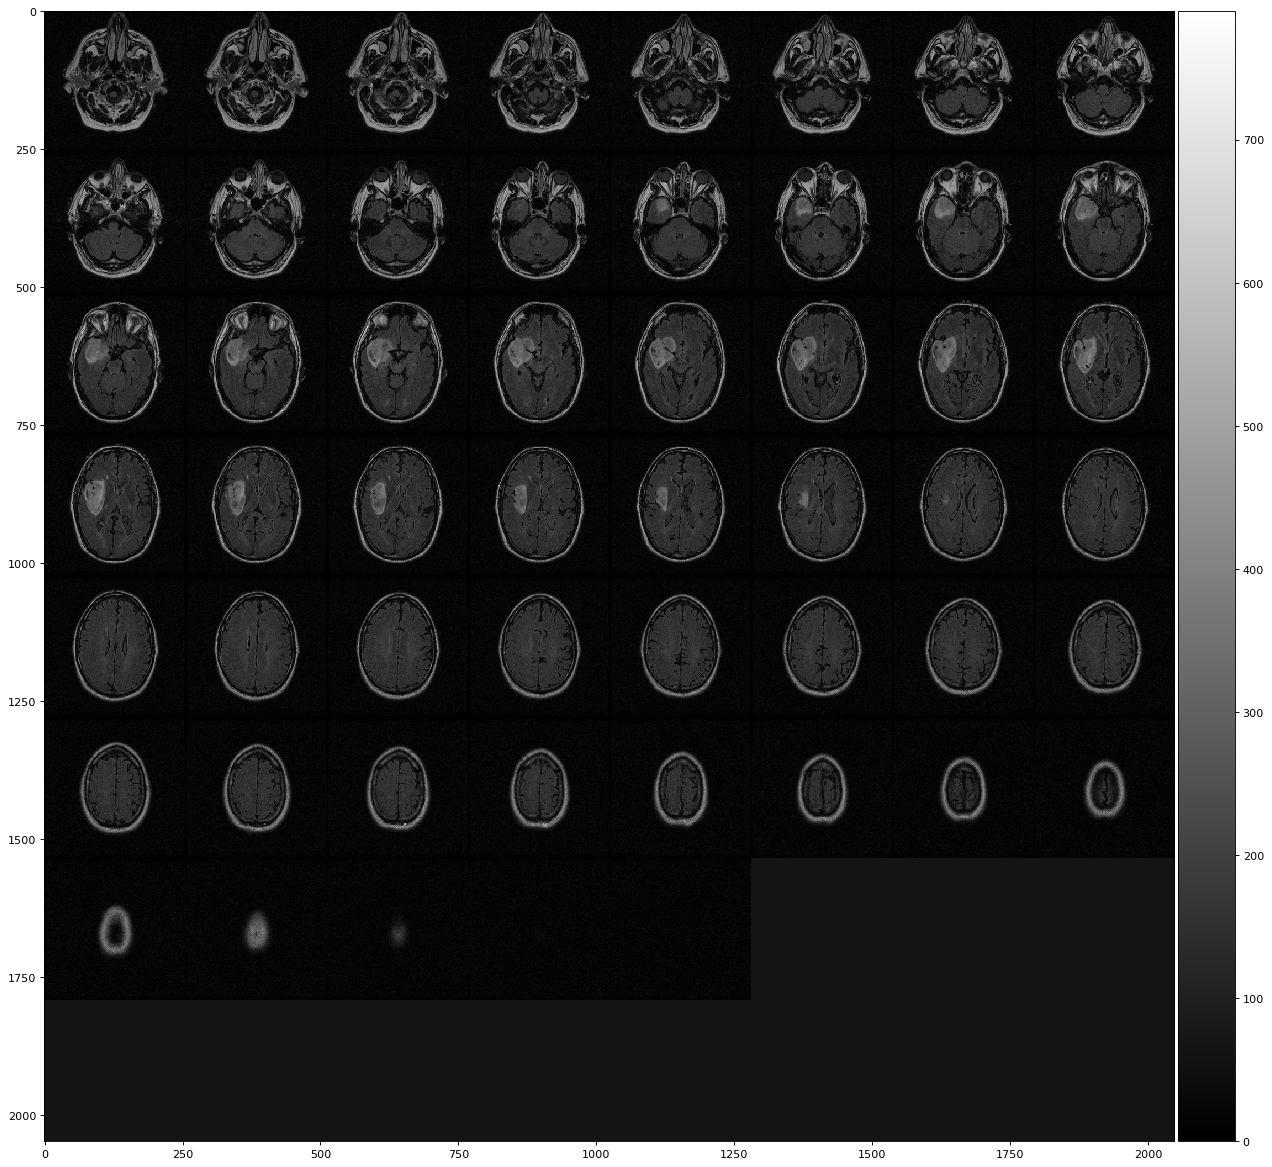

In [237]:
plt.figure(figsize=(16, 16), dpi=80)
m = skimage.util.montage(img_arr)
skimage.io.imshow(m, cmap=plt.cm.gray)
plt.show()


In [238]:
import skimage.morphology as morphology
from sklearn.cluster import KMeans
import numpy as np
def get_inside(img):
    # row_size = img.shape[0]
    # col_size = img.shape[1]
    #
    # mean = np.mean(img)
    # std = np.std(img)
    # img = img - mean
    # img = img / std
    #
    # middle = img[int(col_size / 5):int(col_size / 5 * 4), int(row_size / 5):int(row_size / 5 * 4)]
    # mean = np.mean(middle)
    # max = np.max(img)
    # min = np.min(img)
    #
    #
    # img[img == max] = mean
    # img[img == min] = mean

    #kmeans = KMeans(n_clusters=2).fit(np.reshape(middle, [np.prod(middle.shape), 1]))
    kmeans = KMeans(n_clusters=2).fit(img)

    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img < threshold, 1.0, 0.0)  # threshold the image


    eroded = morphology.erosion(thresh_img, np.ones([3, 3]))
    dilation = morphology.dilation(eroded, np.ones([5, 5]))
    return dilation

In [276]:
def bounding_image(image):
    out_image = image.copy()
    for row in range(0, out_image.shape[1]):
        for col in range(0, out_image.shape[0]):
            if out_image[row][col] < 200:
                out_image[row][col] = 0
            elif out_image[row][col] > 375:
                out_image[row][col] = 0
    return out_image

In [240]:
def apply_brainmask(image):
    brain_mask = 1 - get_inside(image)
    return (brain_mask * image)

In [241]:
import cv2

def standard_255(image):
    max_val = np.max(image)
    out_image = image / max_val
    out_image = out_image * 255
    return out_image.astype("uint8")


In [242]:
def get_tumor_mask(image):
    image = bounding_image(image)
    image = apply_brainmask(image)
    image = standard_255(image)

    blurred = cv2.GaussianBlur(image,(7,7),cv2.BORDER_DEFAULT)
    (thresh, im_bw) = cv2.threshold(blurred, 125, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    (cnts, _) = cv2.findContours(im_bw.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #(cnts, _) = cv2.findContours(im_bw.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    mask = np.zeros(image.shape)
    if len(cnts) > 0:
        c = max(cnts, key = cv2.contourArea)
        #cv2.drawContours(mask, cnts, -1, (255,255,255), 3)
        cv2.fillPoly(mask, pts =[c], color=(1))

    return mask

In [280]:
tmp_img = img_arr.copy()[image_num]
#tmp_img = bounding_image(tmp_img)
# tmp_img = apply_brainmask(tmp_img)
#tmp_img = get_inside(tmp_img)
# tmp_img = standard_255(tmp_img)
# blurred = cv2.GaussianBlur(tmp_img,(7,7),cv2.BORDER_DEFAULT)
# (thresh, im_bw) = cv2.threshold(blurred, 125, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
plt.figure(figsize=(16, 16), dpi=80)
plt.imshow(tmp_img, cmap=plt.cm.gray)
#plt.imshow(tmp_img, cmap=plt.cm.gray)
plt.show()


In [244]:
def get_interest_areas(image_set, mask_set, dilate=7):
    image_masks = []
    for index, single_image in enumerate(image_set):
        # print("On image", index)
        # print("Energy is", np.sum(single_image))
        try:
            if (np.sum(single_image) > 100000) and (index in mask_set):
                tmp_mask = get_tumor_mask(single_image)
                if dilate:
                    image_masks.append(morphology.dilation(tmp_mask, np.ones([dilate, dilate])))
                else:
                    image_masks.append(tmp_mask)
            else:
                image_masks.append(np.zeros(single_image.shape))
        except:
            image_masks.append(np.zeros(single_image.shape))
    return image_masks

/Users/zacharyobrien/miniforge3/envs/5215-Project-1/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


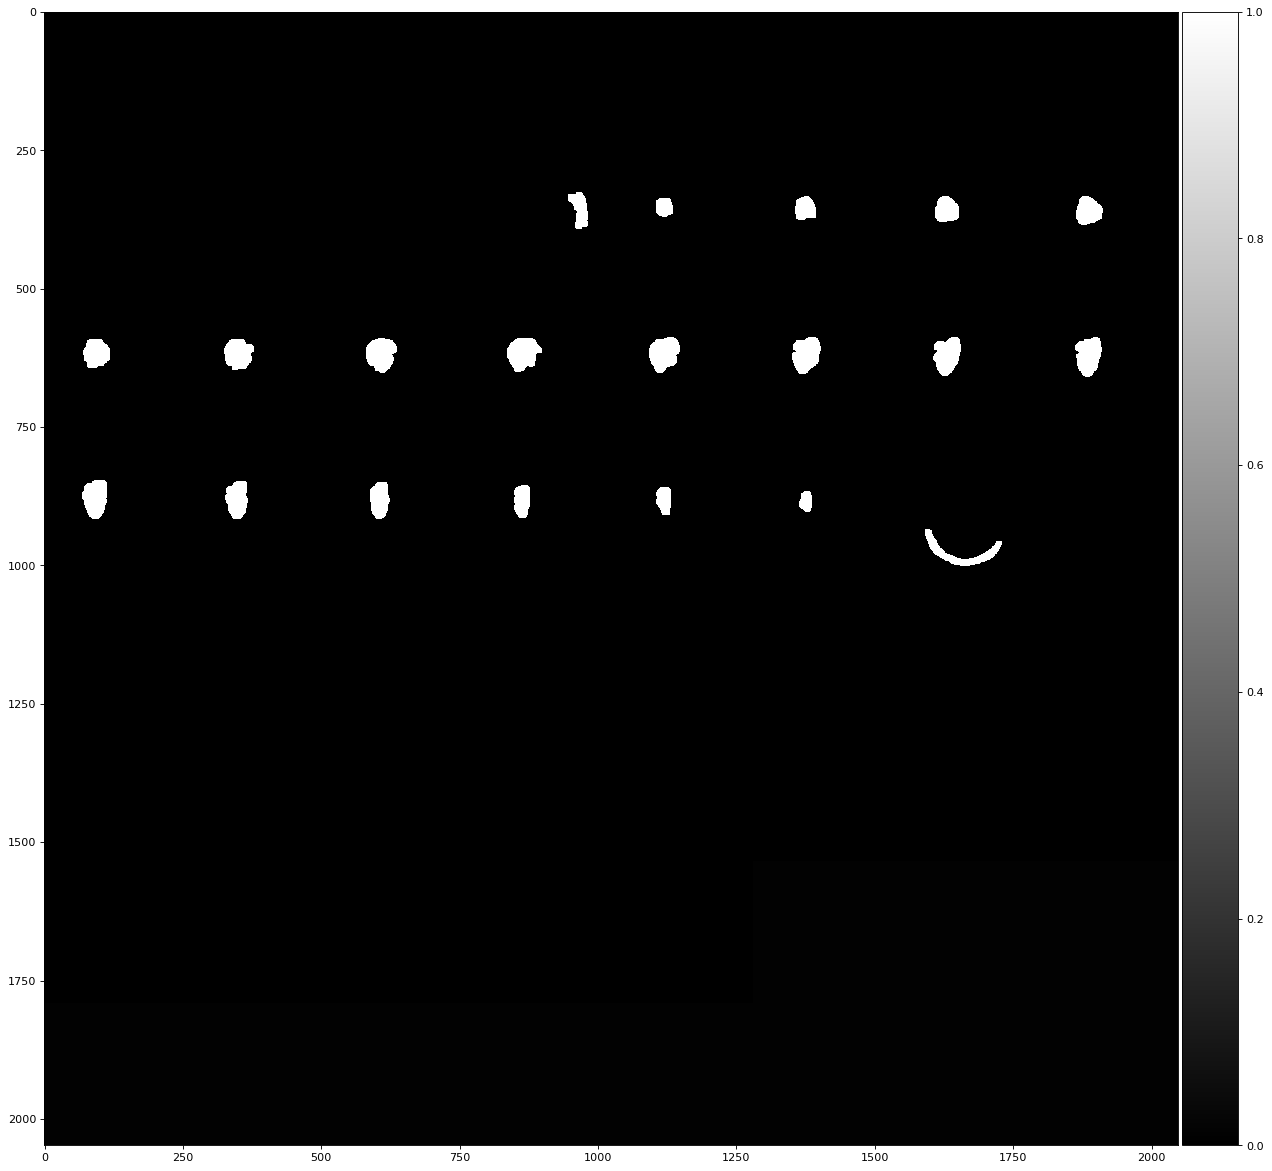

In [245]:
mask_arr = get_interest_areas(img_arr, [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                                 23, 24, 25, 26, 27, 28, 29, 30])

plt.figure(figsize=(16, 16), dpi=80)
m = skimage.util.montage(mask_arr)
skimage.io.imshow(m, cmap=plt.cm.gray)
plt.show()

/Users/zacharyobrien/miniforge3/envs/5215-Project-1/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


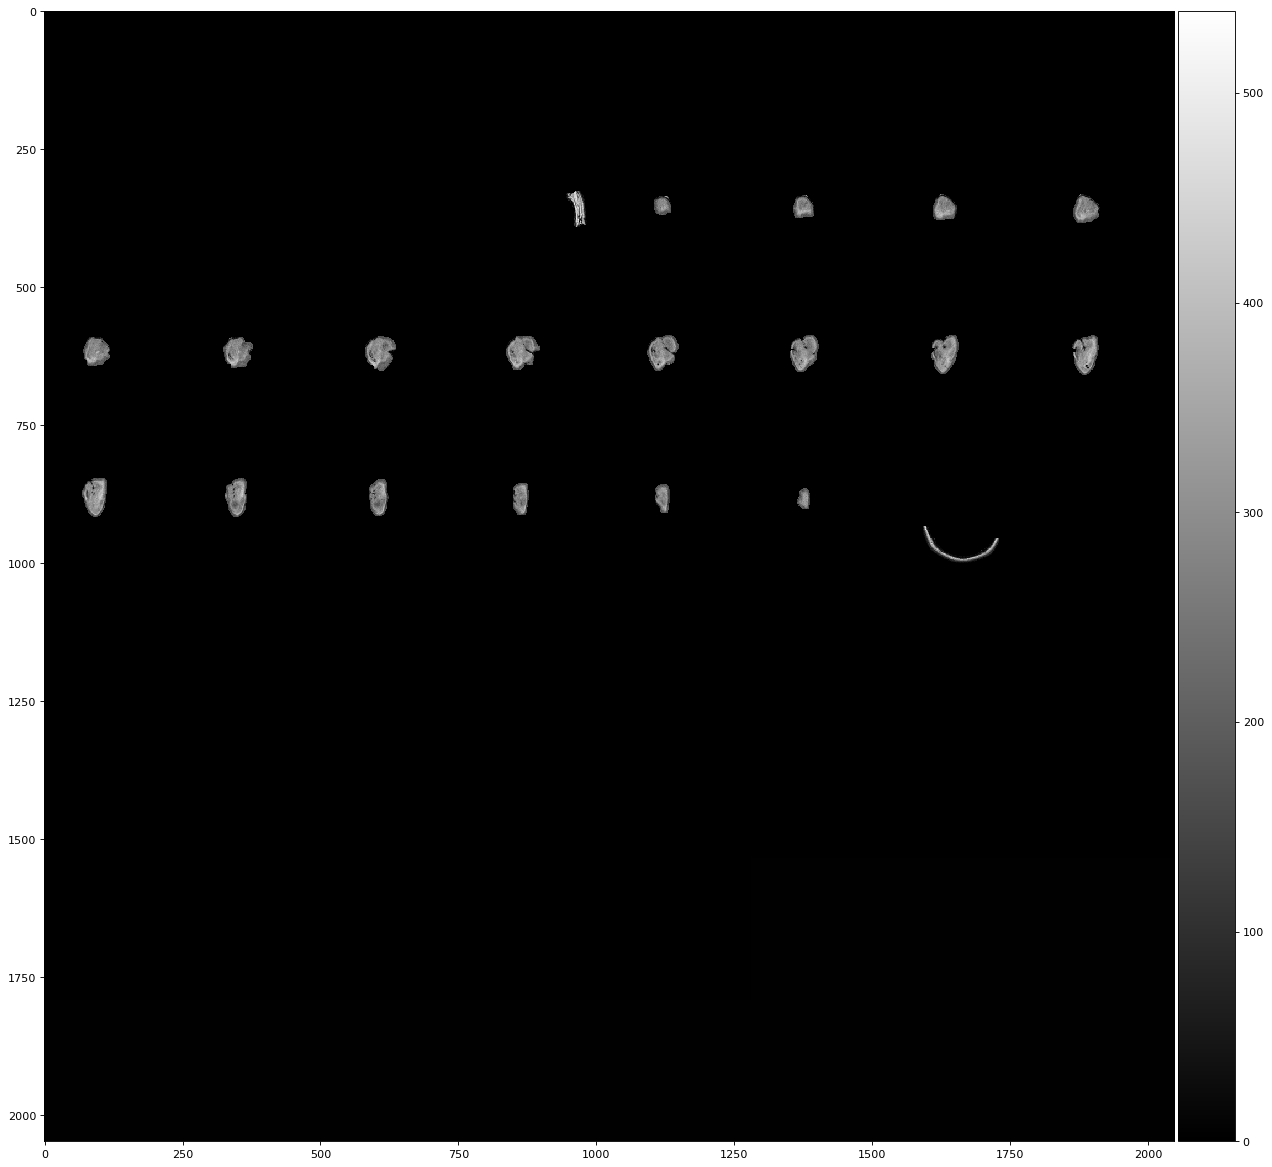

In [246]:
img_arr = []
meta_arr = []
for file in sorted(onlyfiles):
    tmp_file = dicom.read_file(join(data_path, file))
    img_arr.append(tmp_file.pixel_array)
    meta_arr.append(tmp_file.file_meta)

narrow_images = img_arr.copy()
for index, image in enumerate(narrow_images):
    narrow_images[index] = image * mask_arr[index]

plt.figure(figsize=(16, 16), dpi=80)
m = skimage.util.montage(narrow_images)
skimage.io.imshow(m, cmap=plt.cm.gray)
plt.show()

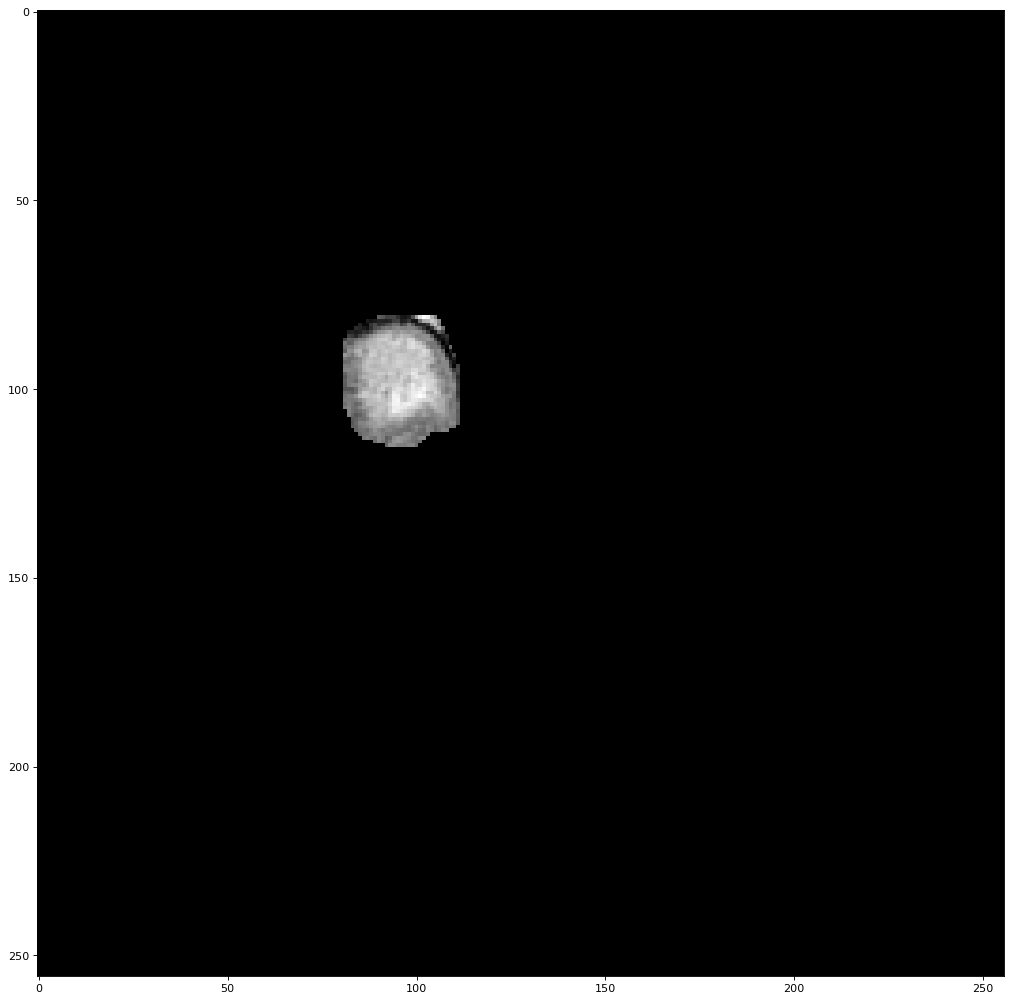

In [247]:
plt.figure(figsize=(16, 16), dpi=80)
plt.imshow(narrow_images[12], cmap=plt.cm.gray)
plt.show()

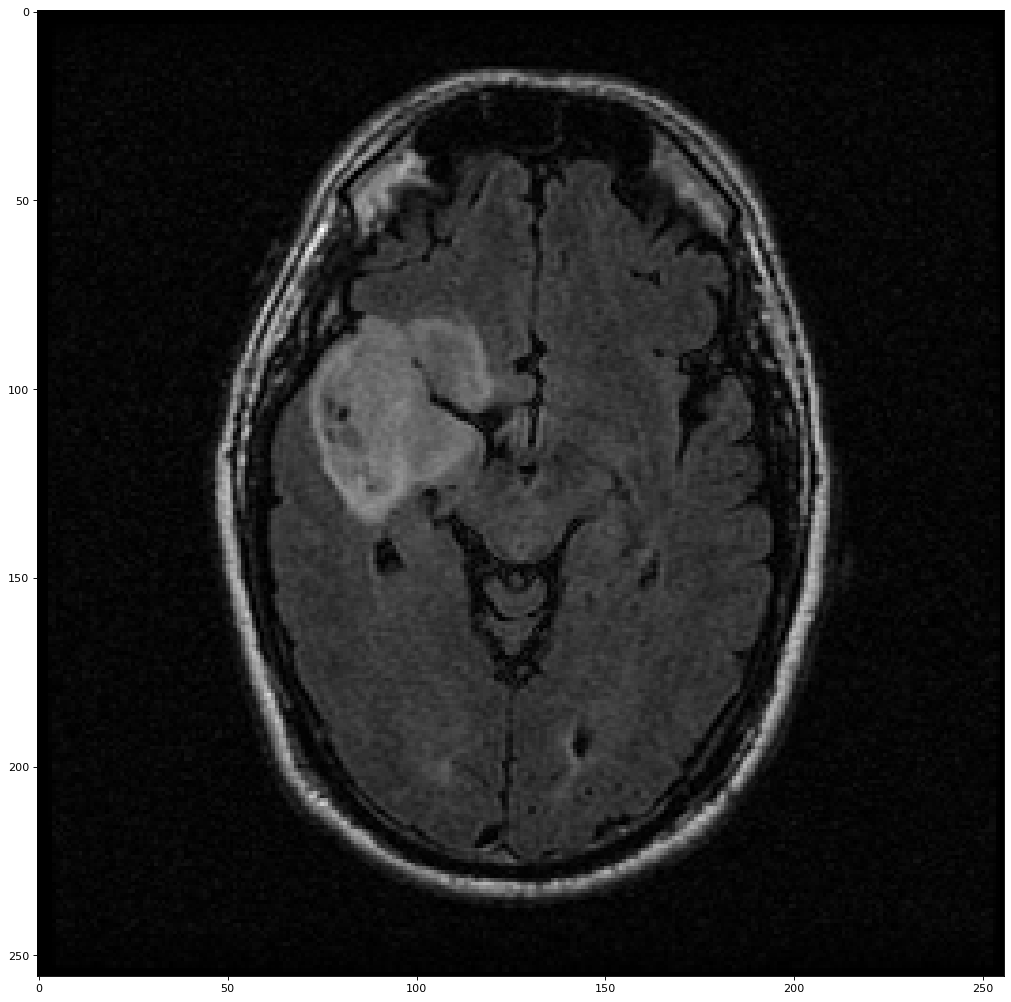

In [248]:
plt.figure(figsize=(16, 16), dpi=80)
plt.imshow(img_arr[19], cmap=plt.cm.gray)
#plt.imshow(tmp_img, cmap=plt.cm.gray)
plt.show()

/var/folders/tm/mxj8z53n0pbbt53crmv3xpl00000gn/T/ipykernel_32059/2744015489.py:28: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  m = skimage.util.montage(final_images, multichannel=True)


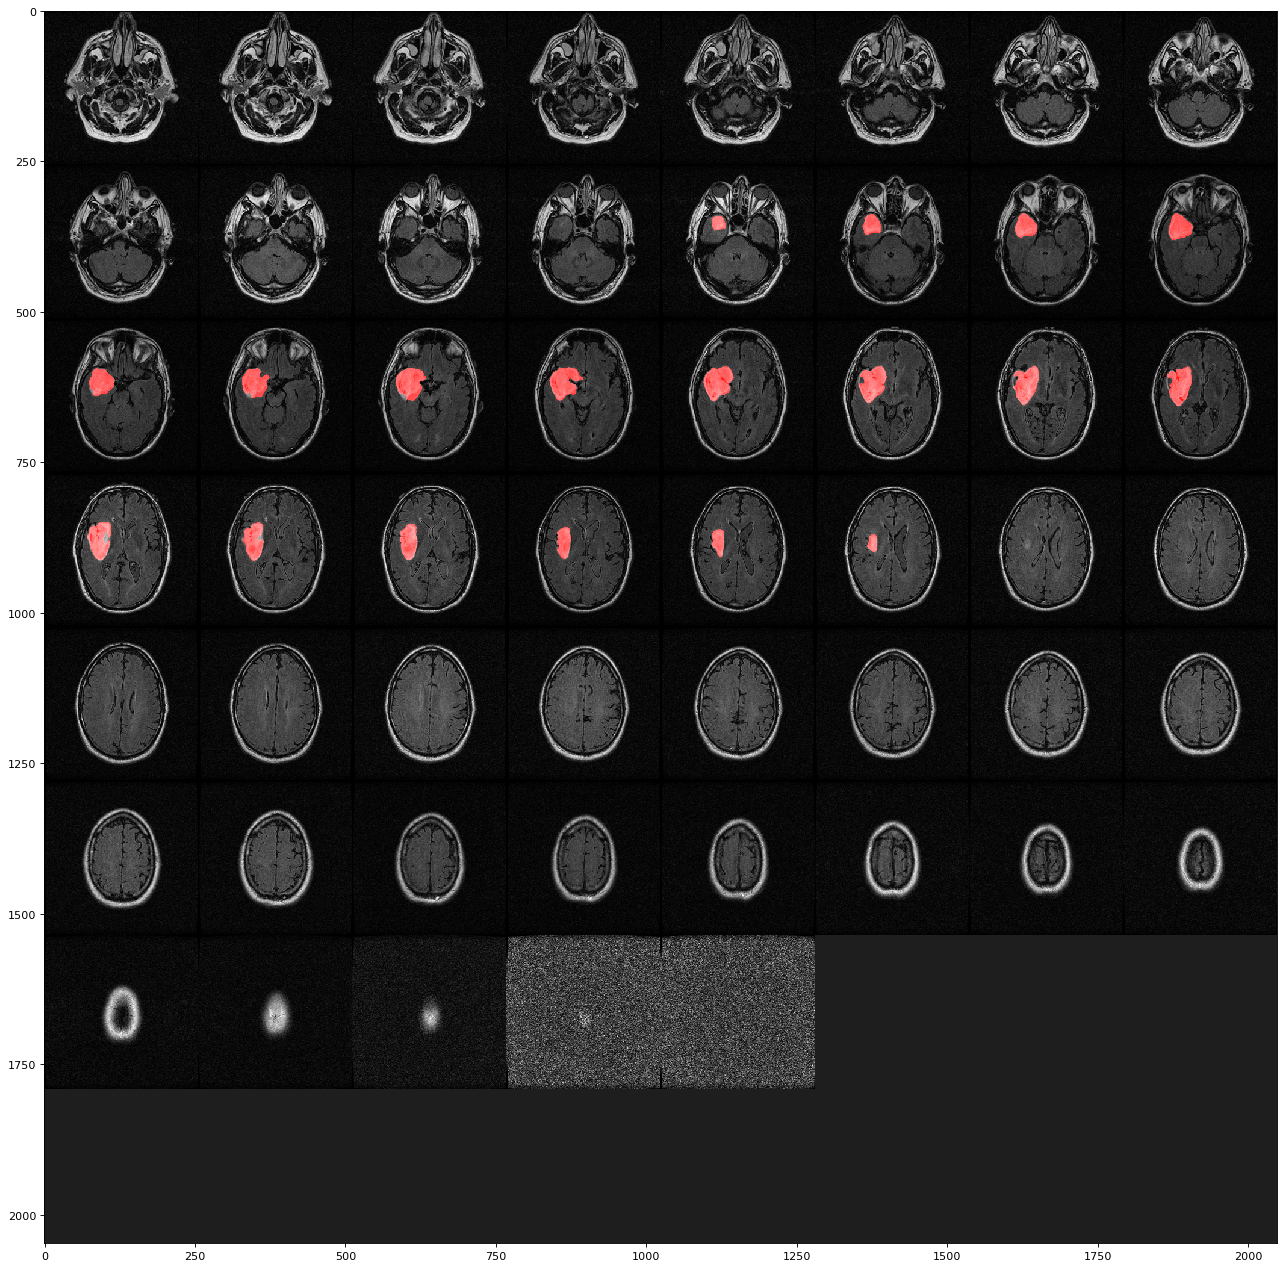

In [249]:
final_masks = get_interest_areas(narrow_images, [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                                 23, 24, 25, 26, 27, 28, 29], dilate=False)
img_arr = []
meta_arr = []
for file in sorted(onlyfiles):
    tmp_file = dicom.read_file(join(data_path, file))
    img_arr.append(tmp_file.pixel_array)
    meta_arr.append(tmp_file.file_meta)

final_images = img_arr.copy()
for index, image in enumerate(final_images):
    image = np.asarray(image)
    image = standard_255(image)
    image = image.reshape((256, 256, 1))
    color_img = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    color_mask = final_masks[index]
    color_mask = color_mask.reshape((256, 256, 1)).astype("uint8")
    color_mask = cv2.cvtColor(color_mask, cv2.COLOR_GRAY2RGB)

    turn_green = np.full((256,256,3), [255, 0, 0], dtype="uint8")
    color_mask = color_mask * turn_green

    # print(color_img[100,100])
    final_images[index] = np.bitwise_or(color_img, color_mask)

plt.figure(figsize=(16, 16), dpi=80)
m = skimage.util.montage(final_images, multichannel=True)
skimage.io.imshow(m, cmap=plt.cm.gray)
plt.show()

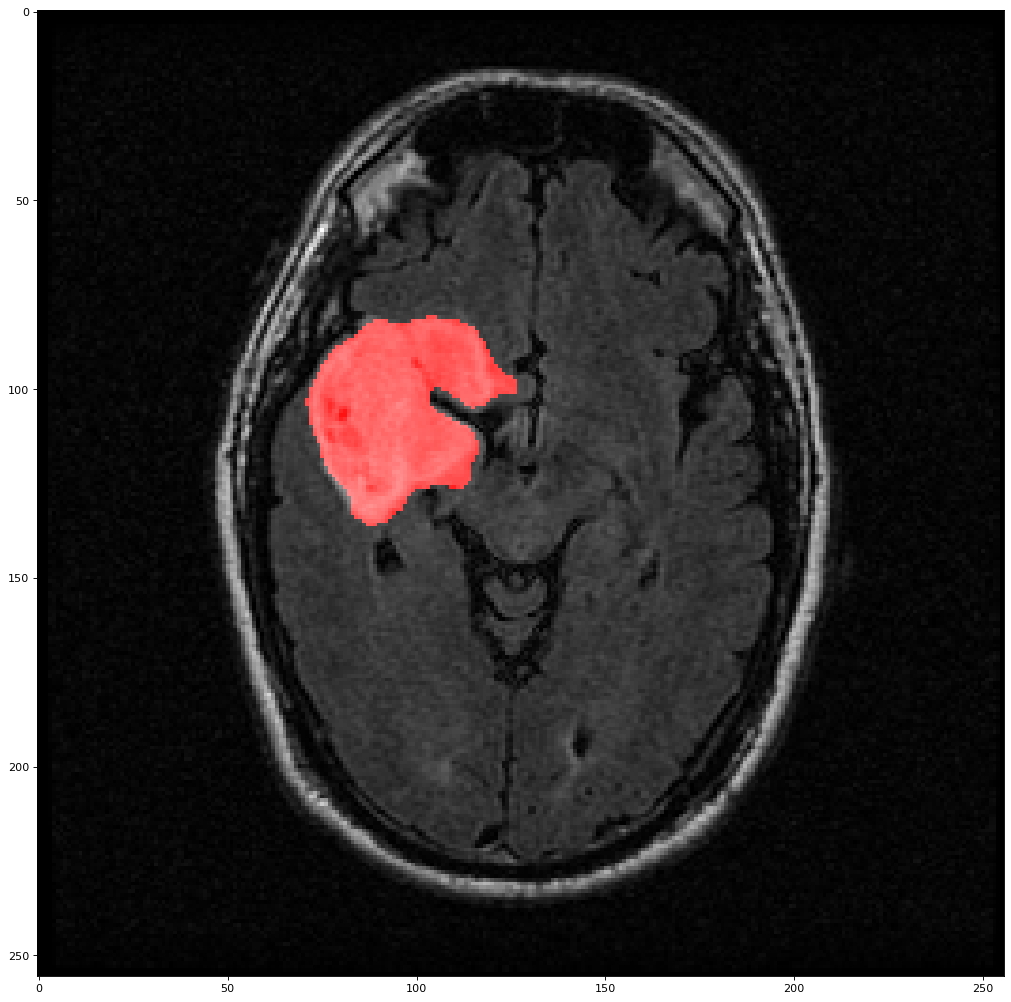

In [250]:
plt.figure(figsize=(16, 16), dpi=80)
plt.imshow(final_images[19], cmap=plt.cm.gray)
plt.show()

In [251]:
#test_img
spacing = test_img.PixelSpacing
thick = test_img.SliceThickness
ax_aspect = spacing[1]/spacing[0]
sag_aspect = spacing[1]/ax_aspect
cor_aspect = ax_aspect/spacing[0]

In [252]:
print(spacing)
print(thick)

[0.938, 0.938]
3.000


In [253]:
img_shape = list((256, 256))
img_shape.append(len(final_images) * 3)
img_shape.append(3)
img3d = np.full(img_shape, [0, 0, 0])
# fill 3D array with the images from the files
stacked_images = []
vert_ratio = int(thick / spacing[0])
for image in final_images:
    for rep in range(0,vert_ratio):
        stacked_images.append(image)
for i, s in enumerate(stacked_images):
    img2d = s
    img3d[:, :, i] = img2d

In [254]:
print(img3d.shape)
print(img3d[:, :, img_shape[2]//2,:].shape)
print(img3d[:, img_shape[1]//2, :,:].shape)
print(img3d[img_shape[0]//2, :, :,:].shape)
print(np.max(img3d[:, img_shape[1]//2, :,:]))

(256, 256, 159, 3)
(256, 256, 3)
(256, 159, 3)
(256, 159, 3)
255


In [255]:
print(img_shape[2]//2)
print(img_shape[1]//3)
print(img_shape[1]//2)
print(img_shape[0]//2)

79
85
128
128


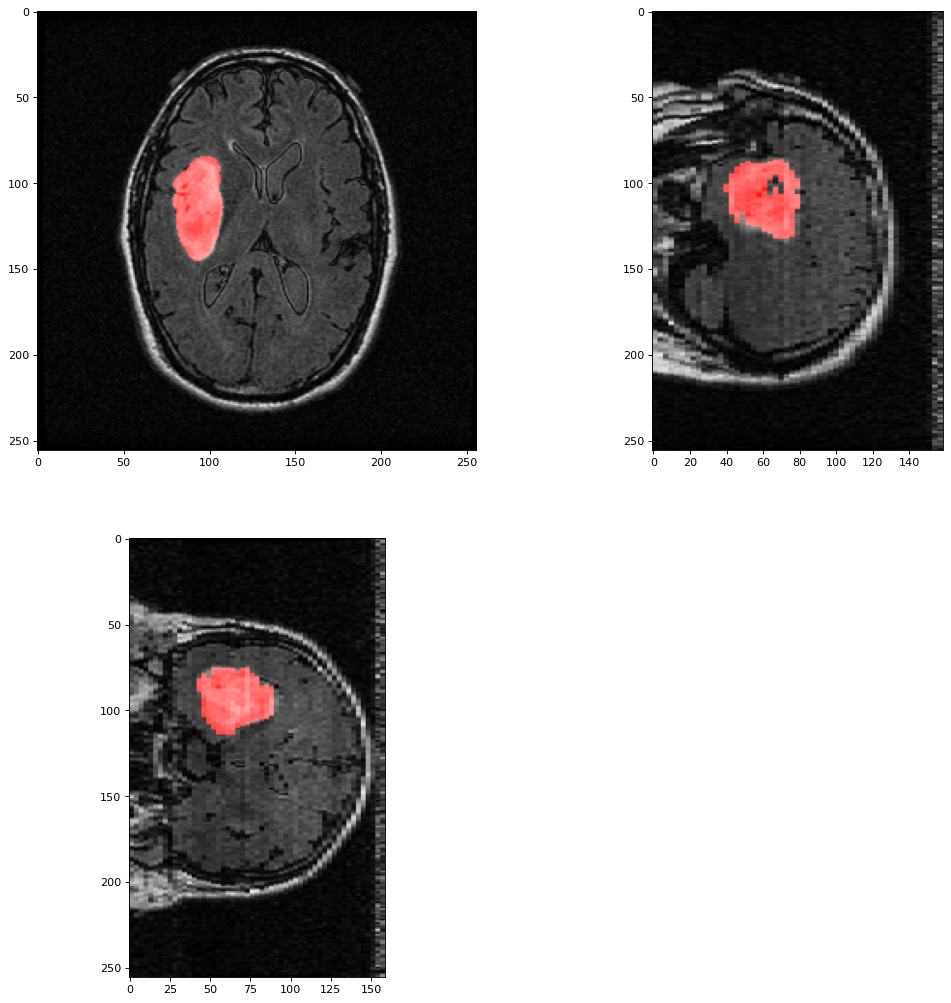

In [256]:
# plot 3 orthogonal slices
plt.figure(figsize=(16, 16), dpi=80)
a1 = plt.subplot(2, 2, 1)
plt.imshow(img3d[:, :, 80,:])
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, 80, :,:])
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 3)
plt.imshow(img3d[120, :, :,:])
a3.set_aspect(cor_aspect)

plt.show()